In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec as gs
%matplotlib inline
plt.style.use('bmh')
from scipy import stats as ss
import seaborn as sns
sns.set_style('dark')
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RandomizedSearchCV, RepeatedKFold
from sklearn.metrics import f1_score, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV, LinearRegression, RidgeCV, LassoCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import class_weight

# the big boy stuff
import tensorflow.keras.metrics as metric
from keras.models import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [2]:
n = 1000 # number of students
def grades(lower, upper, mean, std, n=n): # get an array of grades in a range and distribution parameters
    return [int(x) for x in (ss.truncnorm.rvs(((lower - mean) / std), ((upper - mean) / std), loc=mean, scale=std, size=n))]

### Gathering grades
#### Labs

In [3]:
Lab = dict()
for _ in range(1, 9):
    Lab[_] = grades(0, 11, 6, 3)
for key, item in Lab.items():
    print(f"Lab {key} -> {item[:10]}")

Lab 1 -> [7, 1, 4, 6, 10, 9, 10, 6, 4, 5]
Lab 2 -> [9, 7, 8, 5, 7, 3, 4, 4, 6, 5]
Lab 3 -> [4, 1, 3, 7, 1, 4, 4, 8, 7, 4]
Lab 4 -> [3, 8, 8, 6, 6, 8, 5, 6, 8, 6]
Lab 5 -> [6, 3, 4, 5, 8, 4, 3, 5, 2, 6]
Lab 6 -> [3, 4, 4, 7, 7, 0, 9, 6, 9, 10]
Lab 7 -> [0, 8, 5, 7, 10, 7, 6, 0, 3, 3]
Lab 8 -> [8, 6, 7, 5, 3, 7, 4, 8, 4, 8]


In [4]:
for _ in range(11):
    print(f"{_} -> {Lab[1].count(_)}")

0 -> 29
1 -> 59
2 -> 66
3 -> 98
4 -> 130
5 -> 136
6 -> 139
7 -> 124
8 -> 96
9 -> 80
10 -> 43


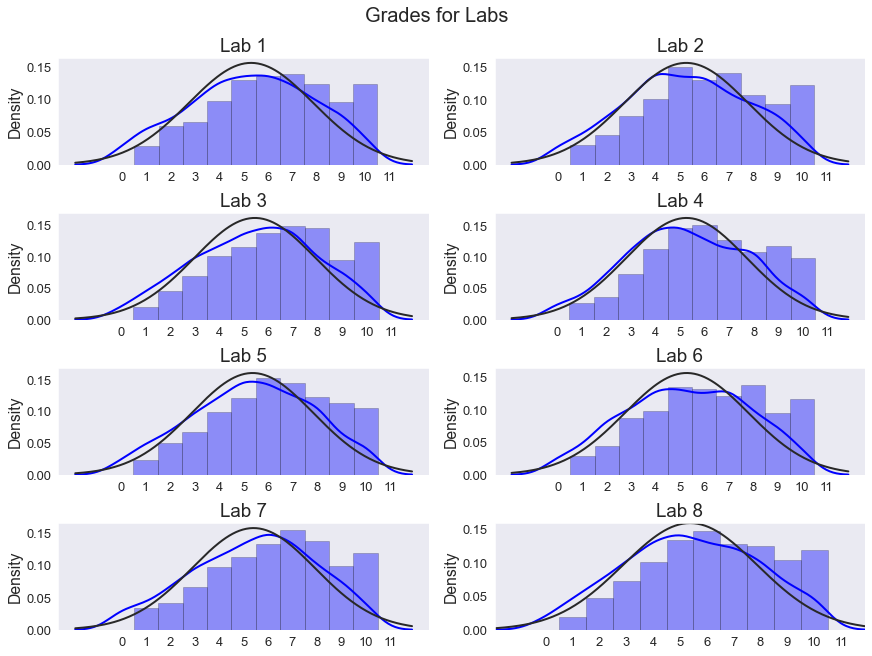

In [58]:
fig = plt.figure(constrained_layout=True, figsize=(12, 9))
grid = gs(nrows=4, ncols=2, figure=fig)
for _ in range(8):
    ax = fig.add_subplot(grid[_])
    # comparing distribution of grades to a regular normal distribution line
    sns.distplot(Lab[(_+1)], fit=ss.norm, ax=ax, norm_hist=True, color='blue', 
                 hist_kws=dict(edgecolor='black', align='right', color='blue'), bins=10)
    plt.xticks(range(0, 12))
    ax.set_title(f"Lab {_+1}")
fig.suptitle('Grades for Labs', fontsize=20)
plt.margins(0.001, 0.001)
grid.tight_layout(fig)
plt.show()

#### Assignments (surprise test)

In [6]:
Assignment = dict()
for _ in range(1, 5):
    Assignment[_] = grades(0, 21, 12, 6)
for key, item in Assignment.items():
    print(f"Assignment {key} -> {item[:10]}")

Assignment 1 -> [7, 10, 17, 13, 6, 6, 11, 13, 3, 16]
Assignment 2 -> [17, 19, 4, 14, 1, 19, 1, 18, 18, 11]
Assignment 3 -> [9, 9, 6, 9, 16, 16, 10, 16, 9, 17]
Assignment 4 -> [6, 2, 10, 16, 8, 7, 11, 14, 5, 16]


In [7]:
for _ in range(21):
    print(f"{_} -> {Assignment[1].count(_)}")

0 -> 13
1 -> 17
2 -> 20
3 -> 23
4 -> 45
5 -> 39
6 -> 37
7 -> 57
8 -> 52
9 -> 76
10 -> 59
11 -> 75
12 -> 82
13 -> 60
14 -> 65
15 -> 60
16 -> 52
17 -> 59
18 -> 38
19 -> 37
20 -> 34


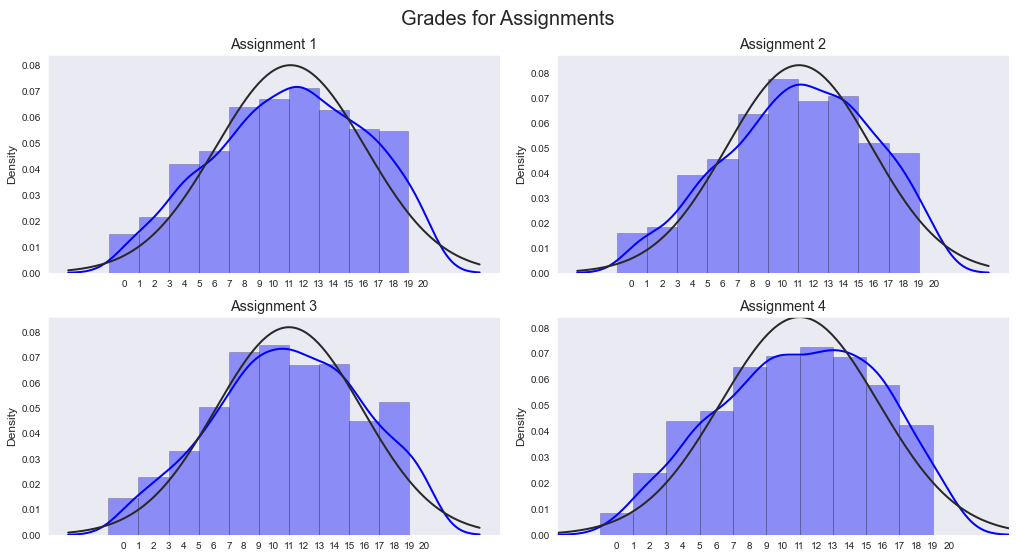

In [8]:
fig = plt.figure(constrained_layout=True, figsize=(14, 14))
grid = gs(nrows=4, ncols=2, figure=fig)
for _ in range(4):
    ax = fig.add_subplot(grid[_])
    # comparing distribution of grades to a regular normal distribution line
    sns.distplot(Assignment[(_+1)], fit=ss.norm, ax=ax, norm_hist=True, color='blue', 
                 hist_kws=dict(edgecolor='black', align='left', color='blue'), bins=10)
    ax.set_title(f"Assignment {_+1}")
    plt.xticks(range(0, 21))
fig.suptitle('Grades for Assignments', fontsize=20)
plt.margins(0.001, 0.001)
grid.tight_layout(fig)
plt.show()

#### Mid-Terms 

In [9]:
Mid_term = grades(0, 51, 30, 16)
print(f"Mid-Term -> {Mid_term[:10]}")

Mid-Term -> [30, 1, 26, 28, 22, 28, 27, 17, 39, 39]


In [10]:
for _ in range(0, 41, 10):
    c = 0
    for __ in range(_,( _ + 11)):
        c += Mid_term.count(__)
    print(f"{_}-{_+10} -> {c}")

0-10 -> 105
10-20 -> 225
20-30 -> 281
30-40 -> 297
40-50 -> 181


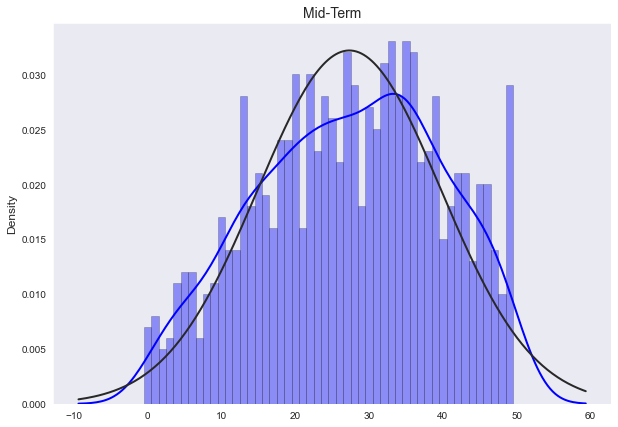

In [11]:
plt.figure(figsize=(10, 7))
sns.distplot(Mid_term, fit=ss.norm, norm_hist=True, color='blue', 
             hist_kws=dict(edgecolor='black', align='left', color='blue'), bins=50)
plt.title('Mid-Term', fontsize=14)
plt.show()

#### Project

In [12]:
Project = grades(0, 101, 60, 33)
print(f"Project -> {Project[:10]}")

Project -> [83, 42, 64, 5, 72, 54, 100, 96, 39, 39]


In [13]:
for _ in range(0, 100, 10):
    c = 0
    for __ in range(_,( _ + 11)):
        c += Project.count(_)
    print(f"{_}-{_+10} -> {c}")

0-10 -> 55
10-20 -> 33
20-30 -> 66
30-40 -> 132
40-50 -> 110
50-60 -> 187
60-70 -> 187
70-80 -> 132
80-90 -> 99
90-100 -> 88


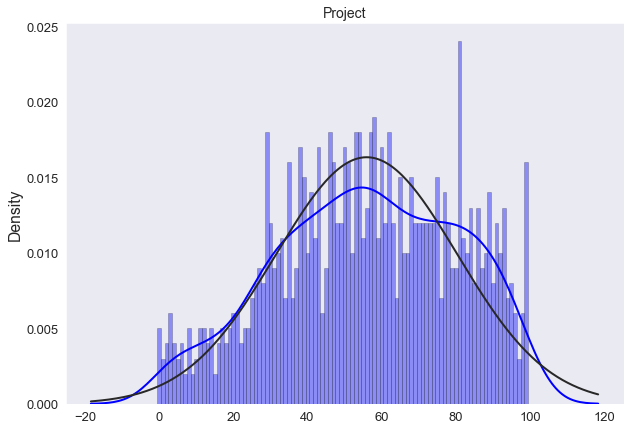

In [53]:
plt.figure(figsize=(10, 7))
sns.distplot(Project, fit=ss.norm, norm_hist=True, color='blue', 
             hist_kws=dict(edgecolor='black', align='left', color='blue'), bins=100)
plt.title('Project', fontsize=14)
plt.show()

#### Final Exam

In [15]:
Final = grades(0, 101, 60, 33)
print(f"Final Exam -> {Final[:10]}")

Final Exam -> [64, 64, 30, 35, 61, 66, 8, 38, 51, 16]


In [16]:
for _ in range(0, 100, 10):
    c = 0
    for __ in range(_,( _ + 11)):
        c += Final.count(_)
    print(f"{_}-{_+10} -> {c}")

0-10 -> 33
10-20 -> 22
20-30 -> 55
30-40 -> 121
40-50 -> 132
50-60 -> 132
60-70 -> 165
70-80 -> 132
80-90 -> 99
90-100 -> 99


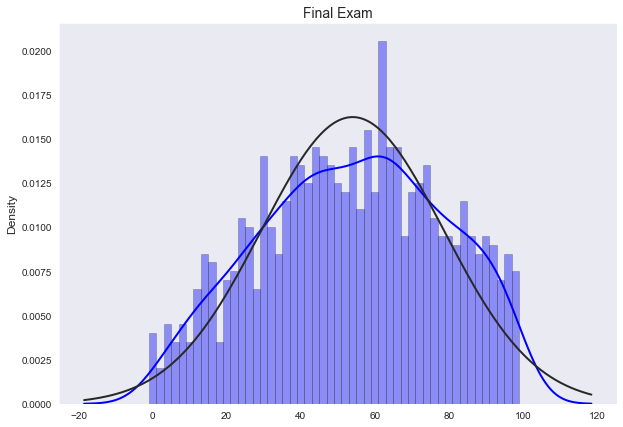

In [17]:
plt.figure(figsize=(10, 7))
sns.distplot(Final, fit=ss.norm, norm_hist=True, color='blue', 
             hist_kws=dict(edgecolor='black', align='left', color='blue'), bins=50)
plt.title('Final Exam', fontsize=14)
plt.show()

### Grade Weights 
Each type of test will contribute this much to the final grade:
* Final Exam = 20%
* Mid-Terms = 10%
* Assignments = 10%
* Labs = 20%
* Project = 40%

Total passing percentage is assumed to be **60%**

### Making the DataFrame 
#### Combining the marks togethe

In [18]:
df = pd.DataFrame(index=range(1, n+1))
df.index.name = 'Student'

# automate the process of inputting the grades for all tests for each student
for _ in range(1, 9):
    df[f"Lab {_}"] = Lab[_]

for _ in range(1, 5):
    df[f"Assignment {_}"] = Assignment[_]
    
df['Mid-Term'] = Mid_term
    
df['Project'] = Project
    
df['Final'] = Final
    
df.head()

,Lab 1,Lab 2,Lab 3,Lab 4,Lab 5,Lab 6,Lab 7,Lab 8,Assignment 1,Assignment 2,Assignment 3,Assignment 4,Mid-Term,Project,Final
Student,,,,,,,,,,,,,,,
1,7,9,4,3,6,3,0,8,7,17,9,6,30,83,64
2,1,7,1,8,3,4,8,6,10,19,9,2,1,42,64
3,4,8,3,8,4,4,5,7,17,4,6,10,26,64,30
4,6,5,7,6,5,7,7,5,13,14,9,16,28,5,35
5,10,7,1,6,8,7,10,3,6,1,16,8,22,72,61


In [19]:
print(f"No. of students -> {len(df)}\nNumber of tests -> {df.shape[1]}")

No. of students -> 1000
Number of tests -> 15


#### Determining if a student passes

In [20]:
Final_percent = 0.2
Mid_term_percent = 0.1
Assignments_percent = 0.1
Labs_percent = 0.2
Project_percent  = 0.4

Calculate the total grade for each category of test, then use that total and calculate the overall percentage of how much it contributes to students (based on the test's weightage) **overall** grade

In [21]:
lab_grades = list(df.iloc[:, :8].apply(lambda x: np.sum(x) / 80, axis=1) * Labs_percent)
assignment_grades = list(df.iloc[:, 8:12].apply(lambda x: np.sum(x) / 80, axis=1) * Assignments_percent)
mid_term_grades = list(df['Mid-Term'].apply(lambda x: (x / 50)*Mid_term_percent))
project_grades = list(df.Project.apply(lambda x: (x / 100) * Project_percent))
final_grades = list(df.Final.apply(lambda x: (x / 100) * Final_percent))

In [22]:
print(f"Lab -> {lab_grades[0]}\nAsgn -> {assignment_grades[0]}\nMid-Term -> {mid_term_grades[0]}\n\
Project -> {project_grades[0]}\nFinal -> {final_grades[0]}")

Lab -> 0.1
Asgn -> 0.04875
Mid-Term -> 0.06
Project -> 0.332
Final -> 0.128


In [23]:
overall_grades = [] # calculate the total grade percentage
for _ in range(n):
    overall_grades.append(np.round((lab_grades[_] + assignment_grades[_] + \
                                    mid_term_grades[_] + final_grades[_] + project_grades[_]) * 100, 3))
overall_grades[:10]

[66.875, 44.3, 52.175, 33.1, 62.275, 56.9, 62.375, 67.775, 48.725, 45.85]

#### Finishing the final table 

In [24]:
df['Total %'] = overall_grades
df['Pass/Fail'] = ["Pass" if x >= 60 else "Fail" for x in overall_grades]
        

df.head()

,Lab 1,Lab 2,Lab 3,Lab 4,Lab 5,Lab 6,Lab 7,Lab 8,Assignment 1,Assignment 2,Assignment 3,Assignment 4,Mid-Term,Project,Final,Total %,Pass/Fail
Student,,,,,,,,,,,,,,,,,
1,7,9,4,3,6,3,0,8,7,17,9,6,30,83,64,66.875,Pass
2,1,7,1,8,3,4,8,6,10,19,9,2,1,42,64,44.300,Fail
3,4,8,3,8,4,4,5,7,17,4,6,10,26,64,30,52.175,Fail
4,6,5,7,6,5,7,7,5,13,14,9,16,28,5,35,33.100,Fail
5,10,7,1,6,8,7,10,3,6,1,16,8,22,72,61,62.275,Pass


In [25]:
print(f"Students failed -> {len(df[df['Pass/Fail'] == 'Fail'])}\nStudents passed -> {len(df[df['Pass/Fail'] == 'Pass'])}")

Students failed -> 663
Students passed -> 337


In [26]:
df.describe().drop(['count', '25%', '50%', '75%'])

,Lab 1,Lab 2,Lab 3,Lab 4,Lab 5,Lab 6,Lab 7,Lab 8,Assignment 1,Assignment 2,Assignment 3,Assignment 4,Mid-Term,Project,Final,Total %
mean,5.305000,5.255000,5.459000,5.263000,5.36300,5.276000,5.404000,5.378000,11.113000,11.071000,11.003000,11.005000,27.331000,55.974000,54.013000,54.858150
std,2.559791,2.540163,2.474761,2.452722,2.48705,2.541709,2.519351,2.501874,4.992911,4.799061,4.873062,4.744627,12.405294,24.443461,24.608747,11.267131
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.850000
max,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,20.000000,20.000000,20.000000,20.000000,50.000000,100.000000,100.000000,81.600000


### Creating excel file 

In [27]:
df.to_excel("Grades.xlsx", sheet_name='Grades')

### Making the Classifier 
#### Preprocessing

In [28]:
df2 = df.copy()
df2.head()

,Lab 1,Lab 2,Lab 3,Lab 4,Lab 5,Lab 6,Lab 7,Lab 8,Assignment 1,Assignment 2,Assignment 3,Assignment 4,Mid-Term,Project,Final,Total %,Pass/Fail
Student,,,,,,,,,,,,,,,,,
1,7,9,4,3,6,3,0,8,7,17,9,6,30,83,64,66.875,Pass
2,1,7,1,8,3,4,8,6,10,19,9,2,1,42,64,44.300,Fail
3,4,8,3,8,4,4,5,7,17,4,6,10,26,64,30,52.175,Fail
4,6,5,7,6,5,7,7,5,13,14,9,16,28,5,35,33.100,Fail
5,10,7,1,6,8,7,10,3,6,1,16,8,22,72,61,62.275,Pass


In [29]:
df_cf_y = LabelEncoder().fit_transform(df2['Pass/Fail']) # classifier (pass/fail) target variable
df_rg_y = df['Total %'] # regressor (total %) target variable
df2.drop(["Final", "Pass/Fail", "Total %"], axis=1, inplace=True)

df2_ = df2.copy() # making copy of feature set to split and scale for classifier and regressor
df2.head()

,Lab 1,Lab 2,Lab 3,Lab 4,Lab 5,Lab 6,Lab 7,Lab 8,Assignment 1,Assignment 2,Assignment 3,Assignment 4,Mid-Term,Project
Student,,,,,,,,,,,,,,
1,7,9,4,3,6,3,0,8,7,17,9,6,30,83
2,1,7,1,8,3,4,8,6,10,19,9,2,1,42
3,4,8,3,8,4,4,5,7,17,4,6,10,26,64
4,6,5,7,6,5,7,7,5,13,14,9,16,28,5
5,10,7,1,6,8,7,10,3,6,1,16,8,22,72


In [30]:
print("Classifier")
print(f"X -> {df2.shape}\ny -> {df_cf_y.shape}")

print("\nRegressor")
print(f"X -> {df2_.shape}\ny-> {df_rg_y.shape}")

Classifier
X -> (1000, 14)
y -> (1000,)

Regressor
X -> (1000, 14)
y-> (1000,)


In [31]:
df_cf_x_train, df_cf_x_test, df_cf_y_train, df_cf_y_test = train_test_split(df2, df_cf_y,
                                                                            stratify=df_cf_y, test_size=.10, 
                                                                            random_state=7)
# scaling classifier feature train and test data
clf_scale = StandardScaler().fit(df_cf_x_train)
df_cf_x_train = clf_scale.transform(df_cf_x_train)
df_cf_x_test = clf_scale.transform(df_cf_x_test)

df_rg_x_train, df_rg_x_test, df_rg_y_train, df_rg_y_test = train_test_split(df2_, df_rg_y, test_size=.10)
# scaling regressor feature train and test data
rg_scale = StandardScaler().fit(df_rg_x_train)
df_rg_x_train = rg_scale.transform(df_rg_x_train)
df_rg_x_test = rg_scale.transform(df_rg_x_test)

print("Classifier")
print(f"Train X -> {df_cf_x_train.shape}\nTrain y -> {df_cf_y_train.shape}")
print(f"Test X -> {df_cf_x_test.shape}\nTest y -> {df_cf_y_test.shape}")

print("\nRegressor")
print(f"Train X -> {df_rg_x_train.shape}\nTrain y -> {df_rg_y_train.shape}")
print(f"Test X -> {df_rg_x_test.shape}\nTest y -> {df_rg_y_test.shape}")

Classifier
Train X -> (900, 14)
Train y -> (900,)
Test X -> (100, 14)
Test y -> (100,)

Regressor
Train X -> (900, 14)
Train y -> (900,)
Test X -> (100, 14)
Test y -> (100,)


#### Setting up the Classifier
##### RandomForestClassifier

In [32]:
rfc = RandomizedSearchCV(estimator=RandomForestClassifier(),
                  param_distributions={'n_estimators':range(700, 1100, 100), 
                                       'warm_start':[True], 'criterion':['entropy']},
                  n_jobs=-1, cv=RepeatedStratifiedKFold(random_state=7), 
                  return_train_score=True, verbose=3, n_iter=100, refit=True)
rfc.fit(df_cf_x_train, df_cf_y_train)
rfc.best_params_

Fitting 50 folds for each of 4 candidates, totalling 200 fits


{'warm_start': True, 'n_estimators': 1000, 'criterion': 'entropy'}

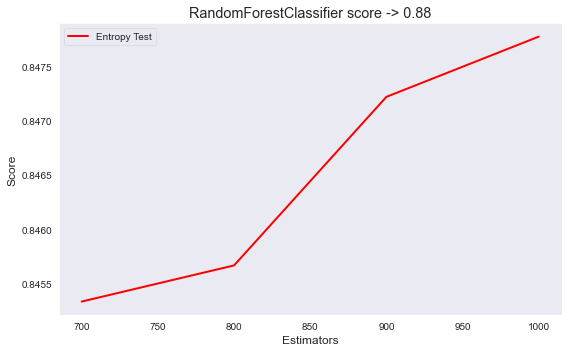

In [33]:
plt.figure(figsize=(8, 5))
plt.title(f"RandomForestClassifier score -> {rfc.score(df_cf_x_test, df_cf_y_test)}")
plt.plot(range(700, 1100, 100), 
         pd.DataFrame(rfc.cv_results_)['mean_test_score'][pd.DataFrame(rfc.cv_results_)['param_criterion'] == 'entropy'], 
         label='Entropy Test', c='red')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.show()

##### LogisticRegressionCV 

In [34]:
logreg = LogisticRegressionCV(cv=RepeatedStratifiedKFold(n_splits=10, random_state=7), 
                             max_iter=1000, n_jobs=-1, verbose=3, refit=True, random_state=7).fit(df_cf_x_train, 
                                                                                                  df_cf_y_train)
logreg.score(df_cf_x_test, df_cf_y_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s finished


0.91

##### KNeighborsClassifier

In [35]:
knn = RandomizedSearchCV(estimator=KNeighborsClassifier(), param_distributions={'n_neighbors':range(55, 66), 
                                                                'weights':['uniform', 'distance'], 
                                                                'n_jobs':[-1]}, 
                  cv=RepeatedStratifiedKFold(random_state=7), n_jobs=-1, return_train_score=True, 
                         verbose=3, refit=True, n_iter=100)
knn.fit(df_cf_x_train, df_cf_y_train)
knn.best_params_

Fitting 50 folds for each of 22 candidates, totalling 1100 fits


{'weights': 'distance', 'n_neighbors': 56, 'n_jobs': -1}

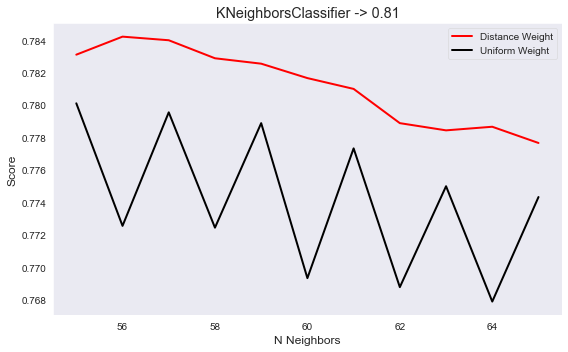

In [36]:
plt.figure(figsize=(8, 5))
plt.plot(range(55, 66), pd.DataFrame(knn.cv_results_)['mean_test_score'][pd.DataFrame(knn.cv_results_)['param_weights'] == 'distance'],
        label='Distance Weight', c='red')
plt.plot(range(55, 66), pd.DataFrame(knn.cv_results_)['mean_test_score'][pd.DataFrame(knn.cv_results_)['param_weights'] == 'uniform'], 
        label='Uniform Weight', c='black')
plt.title(f"KNeighborsClassifier -> {knn.score(df_cf_x_test, df_cf_y_test)}")
plt.xlabel('N Neighbors')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.show()

##### Naive-Bayes Classifier 

In [37]:
gnb = GaussianNB().partial_fit(df_cf_x_train, df_cf_y_train, np.unique(df_cf_y_train))
gnb.score(df_cf_x_test, df_cf_y_test)

0.88

##### Decision Tree Classifier (for fun, not to be used for actual predictions, instead just to have a quick look at the decision tree)

In [38]:
dtc = DecisionTreeClassifier(criterion='entropy').fit(df_cf_x_train, df_cf_y_train)
dtc.score(df_cf_x_test, df_cf_y_test)

0.78

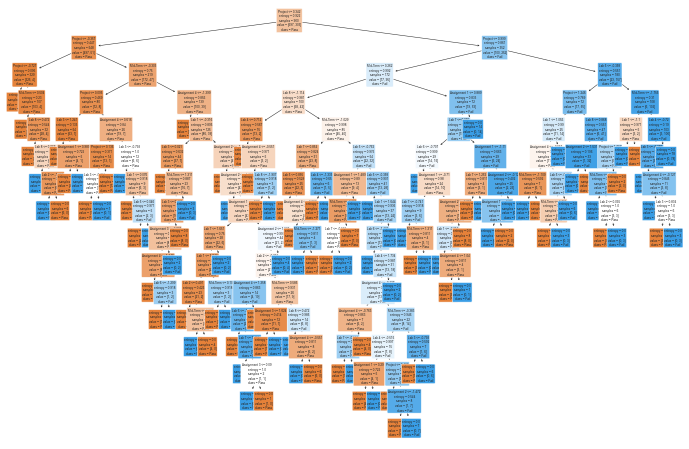

In [39]:
fig = plt.figure(figsize=(12, 8))
dtc_tree = tree.plot_tree(dtc, feature_names=df2.columns, class_names=['Pass', 'Fail'], filled=True, rounded=True,
                         fontsize=3)

##### Gradient Boosting Classifier

In [40]:
gbc = GradientBoostingClassifier(n_estimators=100, max_depth=6, random_state=7, verbose=3, warm_start=True,
                                n_iter_no_change=30).fit(df_cf_x_train, df_cf_y_train)

      Iter       Train Loss   Remaining Time 
         1           1.1457            0.30s
         2           1.0377            0.29s
         3           0.9428            0.29s
         4           0.8634            0.31s
         5           0.7959            0.32s
         6           0.7323            0.31s
         7           0.6742            0.32s
         8           0.6311            0.31s
         9           0.5852            0.31s
        10           0.5459            0.32s
        11           0.5077            0.31s
        12           0.4766            0.31s
        13           0.4478            0.31s
        14           0.4207            0.31s
        15           0.3967            0.31s
        16           0.3723            0.30s
        17           0.3477            0.30s
        18           0.3272            0.30s
        19           0.3058            0.29s
        20           0.2876            0.29s
        21           0.2712            0.29s
        2

In [41]:
gbc.score(df_cf_x_test, df_cf_y_test)

0.86

#####  Evaluating models

In [42]:
models = pd.DataFrame(index=['RandomForestClassifier', 'LogisticRegressionCV', 'KNeighborsClassifier', 
                      'GaussianNB', 'GradientBoosting'])
models.index.name="Algorithms"
models['Score'] = np.round([rfc.score(df_cf_x_test, df_cf_y_test), logreg.score(df_cf_x_test, df_cf_y_test), 
                  knn.score(df_cf_x_test, df_cf_y_test), gnb.score(df_cf_x_test, df_cf_y_test), 
                  gbc.score(df_cf_x_test, df_cf_y_test)], 4) * 100
models['f1 Score'] = np.round([f1_score(df_cf_y_test, rfc.predict(df_cf_x_test)), 
                      f1_score(df_cf_y_test, logreg.predict(df_cf_x_test)),
                     f1_score(df_cf_y_test, knn.predict(df_cf_x_test)),
                     f1_score(df_cf_y_test, gnb.predict(df_cf_x_test)),
                     f1_score(df_cf_y_test, gbc.predict(df_cf_x_test))], 4) * 100
models['Used Model'] = [rfc, logreg, knn, gnb, gbc]
models = models.sort_values(["Score", 'f1 Score'], ascending=False)
models

,Score,f1 Score,Used Model
Algorithms,,,
LogisticRegressionCV,91.0,86.15,LogisticRegressionCV(cv=RepeatedStratifiedKFol...
GaussianNB,88.0,82.35,GaussianNB()
RandomForestClassifier,88.0,81.25,RandomizedSearchCV(cv=RepeatedStratifiedKFold(...
GradientBoosting,86.0,79.41,([DecisionTreeRegressor(criterion='friedman_ms...
KNeighborsClassifier,81.0,62.75,RandomizedSearchCV(cv=RepeatedStratifiedKFold(...


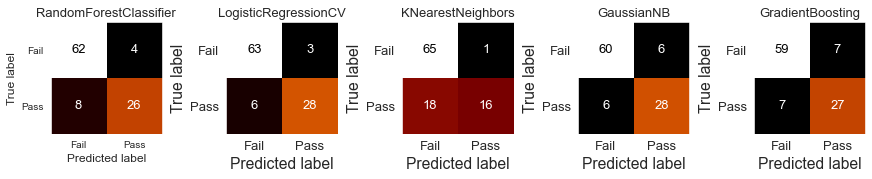

In [43]:
models_list = [rfc, logreg, knn, gnb, gbc]
model_names = ['RandomForestClassifier', 'LogisticRegressionCV', 'KNearestNeighbors', 
               'GaussianNB', 'GradientBoosting']
fig = plt.figure(constrained_layout=True, figsize=(12, 8))
grid = gs(nrows=1, ncols=len(models), figure=fig)
for _ in range(len(models)):
    ax = fig.add_subplot(grid[_])
    plt.rcParams.update({'font.size':13})
    plot_confusion_matrix(models_list[_], df_cf_x_test, df_cf_y_test, labels=[0, 1],
                         display_labels=['Fail', 'Pass'], colorbar=False, ax=ax, cmap='afmhot')
    plt.title(f"{model_names[_]}", fontsize=13)
    
plt.show()

#### Setting up the Regressor

##### LinearRegression

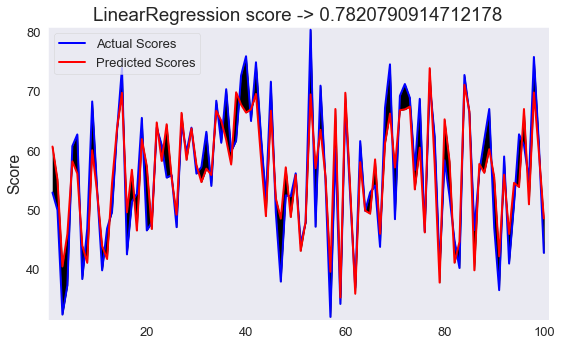

In [44]:
linreg = LinearRegression(n_jobs=-1).fit(df_rg_x_train, df_rg_y_train)

plt.figure(figsize=(8, 5))
plt.title(f"LinearRegression score -> {linreg.score(df_rg_x_test, df_rg_y_test)}")
plt.plot(range(1, len(df_rg_y_test)+1), df_rg_y_test, color='blue', label='Actual Scores')
plt.plot(range(1, len(df_rg_y_test)+1), linreg.predict(df_rg_x_test), color='red', label='Predicted Scores')
plt.fill_between(range(1, len(df_rg_y_test)+1), df_rg_y_test, linreg.predict(df_rg_x_test), color='black')
plt.ylabel('Score')
plt.legend(loc='best')
plt.margins(x=0.01, y=0.01)
plt.tight_layout()
plt.show()

### Example

In [45]:
Lab_1 = 8
Lab_2 = 6
Lab_3 = 6
Lab_4 = 4
Lab_5 = 8
Lab_6 = 7
Lab_7 = 5
Lab_8 = 7

Asgn_1 = 17
Asgn_2 = 12
Asgn_3 = 13
Asgn_4 = 11

MT = 23

Proj = 61

test = [Lab_1, Lab_2, Lab_3, Lab_4, Lab_5, Lab_6, Lab_7, Lab_8,
       Asgn_1, Asgn_2, Asgn_3, Asgn_4,
       MT, Proj]

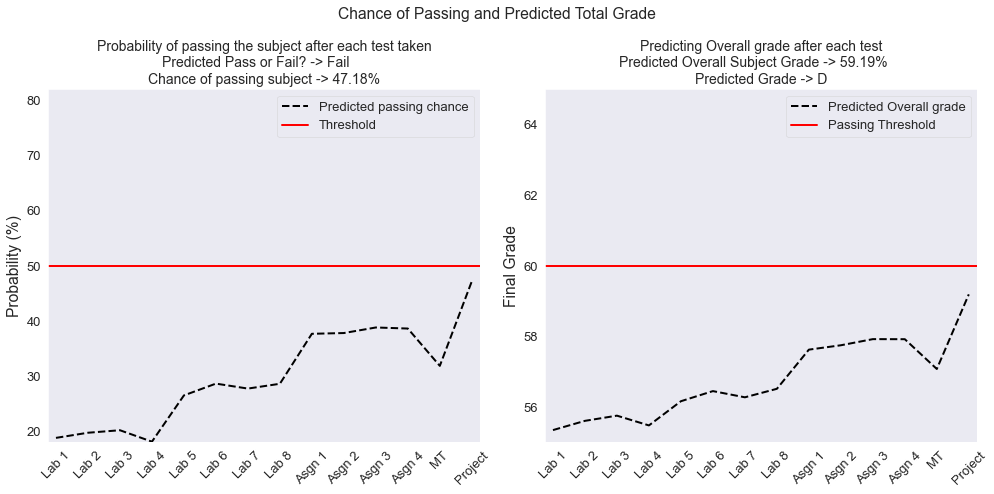

Thank you for using this program!


In [46]:
def calculate(test):
    test_clf = clf_scale.transform(np.array(test).reshape(1, -1)) # scaling for classifier 
    test_rg = rg_scale.transform(np.array(test).reshape(1, -1)) # scaling for regressor
    
    test_ = [0] * len(test_clf[0]) # making dummy list to cummulatively add each test score
    pass_probabs = [] # to store each probability as each test score gets entered
    for x in range(len(test_clf[0])):
        test_[x] = test_clf[0][x]
        pass_probabs.append(models.iloc[0]['Used Model'].predict_proba(np.array([test_]))[0][1] * 100)
        
    limit1 = math.ceil(max([abs(x - 50) for x in pass_probabs]))
    
    pf = None
    if models.iloc[0]['Used Model'].predict(test_clf) == 0:
        pf = 'Fail'
    else:
        pf = 'Pass'
        
    test_ = [0] * len(test_rg[0]) # calculating rolling overall mark percentage
    total_percent = []
    for x in range(len(test_rg[0])):
        test_[x] = test_rg[0][x]
        total_percent.append(np.round(linreg.predict(np.array(test_).reshape(1, -1))[0], 3))
        
    limit2 = math.ceil(max([abs(x-60) for x in total_percent]))
        
    # calculating grade
    grade_p = linreg.predict(test_rg)[0]
    grade = None
    if grade_p >= 90:
        grade = "A+"
    elif grade_p >= 80:
        grade = "A"
    elif grade_p >= 70:
        grade = "B"
    elif grade_p >= 60:
        grade = "C"
    elif grade_p >= 50:
        grade = "D"
    else:
        grade = "F"
        
    fig = plt.figure(figsize=(14,7))
    grid = gs(nrows=1, ncols=2, figure=fig)
    plt.suptitle('Chance of Passing and Predicted Total Grade')
    
    ax1 = fig.add_subplot(grid[:1])
    plt.title(f"Probability of passing the subject after each test taken\nPredicted Pass or Fail? -> {pf}\
    \nChance of passing subject -> {models.iloc[0]['Used Model'].predict_proba(test_clf)[0][1] * 100:.2f}%", fontsize=14)
    plt.plot(['Lab 1', 'Lab 2', 'Lab 3', 'Lab 4', 'Lab 5', 'Lab 6', 'Lab 7', 'Lab 8',
             'Asgn 1', 'Asgn 2', 'Asgn 3', 'Asgn 4',
             'MT', 'Project'], pass_probabs, c='black', linestyle='--', label='Predicted passing chance')
    plt.axhline(50, color='r', label="Threshold")
    plt.xticks(rotation=45)
    plt.ylabel('Probability (%)')
    plt.ylim(ymin=50-limit1, ymax=50+limit1)
    plt.margins(0.02, 0.02)
    plt.legend(loc='best')
    plt.tight_layout()
    
    ax2 = fig.add_subplot(grid[1:])
    plt.title(f"Predicting Overall grade after each test\nPredicted Overall Subject Grade -> {grade_p:.2f}%\
    \nPredicted Grade -> {grade}", 
              fontsize=14)
    plt.plot(['Lab 1', 'Lab 2', 'Lab 3', 'Lab 4', 'Lab 5', 'Lab 6', 'Lab 7', 'Lab 8',
             'Asgn 1', 'Asgn 2', 'Asgn 3', 'Asgn 4',
             'MT', 'Project'], total_percent, c='black', linestyle='--', label='Predicted Overall grade')
    plt.axhline(60, color='r', label='Passing Threshold')
    plt.xticks(rotation=45)
    plt.ylabel('Final Grade')
    plt.margins(x=0.01, y=0.01)
    plt.ylim(ymin=60-limit2, ymax=60+limit2)
    plt.margins(0.02, 0.02)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    return 'Thank you for using this program!'

print(calculate(test))

### Experimenting Neural Network

In [47]:
def neural_model():
    neural_model = Sequential([Dense(128, input_dim=14), Activation('relu'),
                   Dense(64), Activation('relu'),
                   Dense(32), Activation('relu'),
                   Dense(1), Activation('sigmoid')])
    neural_model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
    return neural_model

early_stopping = EarlyStopping(monitor='val_accuracy', verbose=1, patience=15, 
                                                  mode='max', restore_best_weights=True)

scikit_neural = KerasClassifier(build_fn=neural_model)
scikit_neural.fit(df_cf_x_train, df_cf_y_train, epochs=50, batch_size=128, verbose=1, 
                                  use_multiprocessing=True, validation_data=(df_cf_x_test, df_cf_y_test), 
                                  callbacks=early_stopping)

Epoch 1/50
8/8 [==============================] - 1s 45ms/step - loss: 0.6511 - accuracy: 0.6577 - val_loss: 0.5925 - val_accuracy: 0.6700
Epoch 2/50
8/8 [==============================] - 0s 5ms/step - loss: 0.5574 - accuracy: 0.6927 - val_loss: 0.5225 - val_accuracy: 0.7300
Epoch 3/50
8/8 [==============================] - 0s 5ms/step - loss: 0.4854 - accuracy: 0.7718 - val_loss: 0.4505 - val_accuracy: 0.8200
Epoch 4/50
8/8 [==============================] - 0s 5ms/step - loss: 0.4180 - accuracy: 0.8426 - val_loss: 0.3815 - val_accuracy: 0.8500
Epoch 5/50
8/8 [==============================] - 0s 5ms/step - loss: 0.3579 - accuracy: 0.8588 - val_loss: 0.3389 - val_accuracy: 0.8400
Epoch 6/50
8/8 [==============================] - 0s 5ms/step - loss: 0.3198 - accuracy: 0.8659 - val_loss: 0.3096 - val_accuracy: 0.8500
Epoch 7/50
8/8 [==============================] - 0s 5ms/step - loss: 0.2950 - accuracy: 0.8785 - val_loss: 0.2932 - val_accuracy: 0.8600
Epoch 8/50
8/8 [=================

In [48]:
print("f1_score =", f1_score(df_cf_y_test, scikit_neural.predict(df_cf_x_test)))
print("Accuracy =", scikit_neural.score(df_cf_x_test, df_cf_y_test))

f1_score = 0.8695652173913043
4/4 [==============================] - 0s 1ms/step - loss: 0.2711 - accuracy: 0.9100
Accuracy = 0.9100000262260437


In [49]:
print(f"Neural Network probability of passing ->\
 {scikit_neural.predict_proba(clf_scale.transform(np.array(test).reshape(1, -1)))[0][1]*100:.2f}%")

Neural Network probability of passing -> 63.65%


In [50]:
neural_model().summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               1920      
_________________________________________________________________
activation_4 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
activation_5 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
activation_6 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

Restoring model weights from the end of the best epoch.
Epoch 00020: early stopping


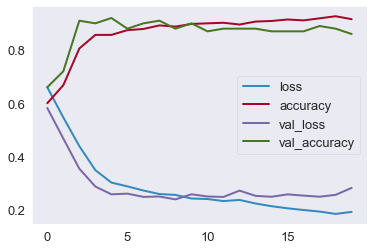

In [51]:
pd.DataFrame(neural_model().fit(df_cf_x_train, df_cf_y_train, epochs=50, batch_size=64, verbose=0,
                       validation_data=(df_cf_x_test, df_cf_y_test), callbacks=early_stopping).history).plot()
plt.show()

In [52]:
_ = metric.TrueNegatives()
_.update_state(df_cf_y_test, scikit_neural.predict(df_cf_x_test))
print('True Negatives =', _.result().numpy())
_ = metric.FalseNegatives()
_.update_state(df_cf_y_test, scikit_neural.predict(df_cf_x_test))
print('False Negatives =', _.result().numpy())

True Negatives = 61.0
False Negatives = 4.0
